In [1]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime
from pytrends.request import TrendReq
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
today = datetime.today()
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "    <tr style=\"text-align: right;\">\n",
C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "      <th></th>\n",
C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "      <td>False</td>\n",
C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "      <td>26</td>\n",
C:\Users\BYoung\Documents\NU Bootcamp Files\New folder\ML.ipynb:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

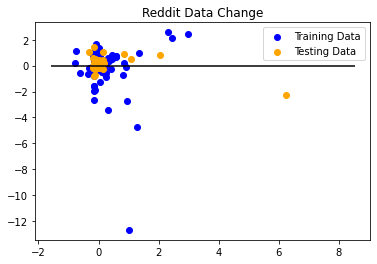

MSE: 0.15319122649933242, R2: 0.8150623337916859


In [2]:
from ipynb.fs.full.ML import *

In [3]:
script = "9ho5HG7o00PT-g"
secret = "2CQTFbYyYp5aLEN7bHkKGO8X4E3YHQ"

In [4]:
posts = pd.read_csv("trimmed_posts.csv")

In [5]:
selected_cols = ['title','selftext']
ticker = 'GME'

In [6]:
try:
    new_df = posts[posts[selected_cols].apply(lambda x: x.str.contains(ticker)).all(axis=1)]
    data = new_df
    data['Ticker'] = ticker
    group_df = new_df.groupby('created_utc') \
       .agg({'id':'count', 'num_comments':'mean', 'score':'mean'}) \
       .rename(columns={'id':'post_count','num_comments':'avg_comments', 'score':'avg_score'}) \
       .reset_index()
    group_df['Ticker'] = ticker
except:
    places = {'created_utc': 0, 'post_count': 0, 'avg_comments': 0, 'avg_score': 0, 'ticker': ticker}
    group_df = pd.DataFrame.from_dict(places)

<ipython-input-6-7c11cac11b67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker


In [7]:
group_df

,created_utc,post_count,avg_comments,avg_score,Ticker
0,2020-12-08,80,145.500000,1.000000,GME
1,2020-12-09,45,52.088889,1.000000,GME
2,2020-12-10,19,33.052632,1.000000,GME
3,2020-12-11,21,34.333333,1.000000,GME
4,2020-12-12,17,39.235294,1.000000,GME
5,2020-12-13,9,79.777778,1.000000,GME
6,2020-12-14,29,51.827586,1.000000,GME
7,2020-12-15,25,19.280000,1.000000,GME
8,2020-12-16,9,47.777778,5.777778,GME
9,2020-12-17,16,46.937500,22.625000,GME


In [8]:
super_posts_df = data.loc[data['score'] > 300]
if not super_posts_df.empty:
    super_posts_df = super_posts_df.groupby(['created_utc', 'Ticker'])['score'].apply(lambda x: (x>=300).sum()).reset_index(name='Count_Score_300')

In [9]:
beginDate = '2020-12-01'
endDate = datetime.today().strftime('%Y-%m-%d')

try:
    pytrend = TrendReq(hl='en-US', tz=360)
    pytrend.build_payload(kw_list=[ticker], timeframe=beginDate + ' ' + endDate, geo='US')
    df = pytrend.interest_over_time()
    df['Noise'] = df[ticker]
    df[ticker]= ticker
    df.index.names = ['Date']
    df.columns = ['Ticker','isPartial', 'Noise']
    mergedNoise = df
except:
    noise = {'Ticker': ticker, 'isPartial': 'No', 'Noise': 0}
    mergedNoise = pd.DataFrame.from_dict(noise)

In [10]:
group_df['created_utc'] = pd.to_datetime(group_df['created_utc'])

if not super_posts_df.empty:
    super_posts_df['created_utc'] = pd.to_datetime(super_posts_df['created_utc'])

In [11]:
merged = group_df.merge(mergedNoise, left_on=['created_utc', 'Ticker'], right_on=['Date', 'Ticker'], how='left')
if not super_posts_df.empty:
    merged = merged.merge(super_posts_df, left_on=['created_utc', 'Ticker'], right_on=['created_utc', 'Ticker'], how="left")
else:
    merged['Count_Score_300'] = 0


In [12]:
merged.drop(columns=['isPartial'])

,created_utc,post_count,avg_comments,avg_score,Ticker,Noise,Count_Score_300
0,2020-12-08,80,145.500000,1.000000,GME,1,NaN
1,2020-12-09,45,52.088889,1.000000,GME,1,NaN
2,2020-12-10,19,33.052632,1.000000,GME,0,NaN
3,2020-12-11,21,34.333333,1.000000,GME,0,NaN
4,2020-12-12,17,39.235294,1.000000,GME,0,NaN
5,2020-12-13,9,79.777778,1.000000,GME,0,NaN
6,2020-12-14,29,51.827586,1.000000,GME,0,NaN
7,2020-12-15,25,19.280000,1.000000,GME,0,NaN
8,2020-12-16,9,47.777778,5.777778,GME,0,NaN
9,2020-12-17,16,46.937500,22.625000,GME,0,NaN


In [13]:
stockData = yf.download(ticker, start=beginDate, end=endDate)
stockData['Ticker'] = ticker
stockReport = pd.DataFrame(stockData, columns= ['Ticker','Adj Close','Volume'])
merged = merged.merge(stockReport, left_on=['created_utc', 'Ticker'], right_on=['Date', 'Ticker'], how='left')

[*********************100%***********************]  1 of 1 completed


In [14]:
merged['post_count_change'] = merged['post_count'].pct_change()
merged['avg_score_change'] = merged['avg_score'].pct_change()
merged['Adj Close_change'] = merged['Adj Close'].pct_change()
merged['Volume_change'] = merged['Volume'].pct_change()
merged.replace([np.inf, -np.inf], 0, inplace=True)
merged.replace([np.inf, -np.inf], 0).dropna(subset=['post_count_change', 'avg_score_change', 'Volume_change'], how="all")
merged = merged.dropna()

In [15]:
expected_posts = merged['post_count'].mean()
expected_avg_comments = merged['avg_comments'].mean()
expected_volume_change = merged['Volume'].mean()
expected_300_count = merged['Count_Score_300'].mean()

In [16]:
#Live API call to Reddit
def df_from_response(res):
    df = pd.DataFrame()

    for post in res.json()['data']['children']:
        df = df.append({
            'subreddit': post['data']['subreddit'],
            'title': post['data']['title'],
            'selftext': post['data']['selftext'],
            'num_comments': post['data']['num_comments'],
            'upvote_ratio': post['data']['upvote_ratio'],
            'date': datetime.fromtimestamp(post['data']['created_utc']).strftime('%Y-%m-%d'),
            'ups': post['data']['ups'],
            'downs': post['data']['downs'],
            'score': post['data']['score'],
            'kind': post['kind'],
            'id': post['data']['id'],
        }, ignore_index=True)
    return df

In [17]:
auth = requests.auth.HTTPBasicAuth(script, secret)
data = {'grant_type': 'password',
        'username': 'NoShare8264',
        'password': 'NewPass227$'}

headers = {'User-Agent': 'Final_Project/0.0.1'}

request = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)
token = f"bearer {request.json()['access_token']}"
headers = {**headers, **{'Authorization': token}}

In [18]:
data = pd.DataFrame()

length = 0
# for i in range(10):
try:
    params = {'limit': 100,
              'q': ticker,
              'restrict_sr': True}
    res = requests.get("https://oauth.reddit.com/r/WallStreetBets/search",
                       headers=headers,
                       params=params)

    new_df = df_from_response(res)
    new_df.sort_values(by=['date'], inplace=True, ascending=False, axis=0)
    row = new_df.iloc[len(new_df)-1]
    fullname = row['kind'] + '_' + row['id']
    params['after'] = fullname
    data = data.append(new_df, ignore_index=True)
except:
    data

In [19]:
data

,date,downs,id,kind,num_comments,score,selftext,subreddit,title,ups,upvote_ratio
0,2021-03-09,0.0,m16emz,t3,68392.0,29198.0,This thread will be automatically stickied wee...,wallstreetbets,"GME Megathread for March 09, 2021",29198.0,0.90
1,2021-03-09,0.0,m16mp5,t3,1119.0,33581.0,,wallstreetbets,GME Hype Trailer,33581.0,0.97
2,2021-03-09,0.0,m1cqod,t3,1088.0,36617.0,"Because looking at the price action, it's $14,...",wallstreetbets,Why I'm selling GME,36617.0,0.85
3,2021-03-09,0.0,m141nm,t3,1601.0,43832.0,,wallstreetbets,🚀🚀 $GME Premarket be like 🚀🚀,43832.0,0.93
4,2021-03-08,0.0,m0q5bm,t3,7856.0,155363.0,,wallstreetbets,GME YOLO update — Mar 8 2021,155363.0,0.89
...,...,...,...,...,...,...,...,...,...,...,...
95,2021-01-25,0.0,l4lmrx,t3,94121.0,18408.0,Thanks all for the quick rise to max comments ...,wallstreetbets,"GME Thoughts, YOLOs, Gains, Stonk Updates, 🚀🚀🚀...",18408.0,0.87
96,2021-01-25,0.0,l4syrd,t3,87043.0,14233.0,Keep all $GME discussion and memes in here. No...,wallstreetbets,GME Megathread Part 2,14233.0,0.89
97,2021-01-22,0.0,l2ljpt,t3,93663.0,14773.0,Don't be doxxing citron or anyone else. That's...,wallstreetbets,GMREEEEEEEEEEEE Containment Thread - GME shitp...,14773.0,0.87
98,2021-01-21,0.0,l1xtan,t3,51537.0,9074.0,No inauguration today so Citron *may* be able ...,wallstreetbets,GME Megathread - Lemon Party 2: Electric Boogaloo,9074.0,0.87


In [20]:
data.to_csv("test.csv")

In [21]:
data['date'] = pd.to_datetime(data['date'])

In [22]:
super_posts_live = data.groupby('date')['score'].apply(lambda x: (x >= 300).sum()).reset_index(name='Count_Score_300')
if not super_posts_live.empty:
    super_posts_live = super_posts_live
else:
    super_posts_live['Count_Score_300'] = 0

In [23]:

try:
    data['Ticker'] = ticker
    live_group = data.groupby('date') \
       .agg({'id':'count', 'num_comments':'mean', 'score':'mean'}) \
       .rename(columns={'id':'post_count','num_comments':'avg_comments', 'score':'avg_score'}) \
       .reset_index()
    live_group['Ticker'] = ticker
except:
    places = {'created_utc': 0, 'post_count': 0, 'avg_comments': 0, 'avg_score': 0, 'ticker': ticker}
    live_group = pd.DataFrame.from_dict(places)

In [24]:
live_group = live_group.merge(super_posts_live, left_on=['date'], right_on=['date'], how="left")

In [25]:
live_group

,date,post_count,avg_comments,avg_score,Ticker,Count_Score_300
0,2021-01-19,1,46954.000000,12031.000000,GME,1
1,2021-01-21,1,51537.000000,9074.000000,GME,1
2,2021-01-22,1,93663.000000,14773.000000,GME,1
3,2021-01-25,2,90582.000000,16320.500000,GME,2
4,2021-01-26,5,77201.200000,37619.600000,GME,5
5,2021-01-27,6,59769.166667,55053.166667,GME,6
6,2021-01-28,6,47430.833333,83070.833333,GME,6
7,2021-01-29,6,41858.166667,107430.166667,GME,6
8,2021-01-30,1,5889.000000,58623.000000,GME,1
9,2021-01-31,1,8024.000000,58087.000000,GME,1


In [26]:
live_group = live_group.merge(stockReport, left_on=['date', 'Ticker'], right_on=['Date', 'Ticker'], how='left')
live_group['Adj Close_change'] = live_group['Adj Close'].pct_change()
live_group['Volume_change'] = live_group['Volume'].pct_change()
live_group['post_count_change'] = live_group['post_count'].pct_change()
live_group['avg_score_change'] = live_group['avg_score'].pct_change()

In [27]:
xfits = live_group[live_group.date > datetime.now() - pd.to_timedelta("3day")]
xfits_dates = xfits['date']
xfittings = xfits[['post_count_change', 'avg_score_change', 'Volume_change', 'Count_Score_300']]

In [28]:
xfittings

,post_count_change,avg_score_change,Volume_change,Count_Score_300
38,2.000000,0.448759,1.068636,3
39,0.333333,-0.579272,0.000000,4


In [29]:
xfits_dates

38   2021-03-08
39   2021-03-09
Name: date, dtype: datetime64[ns]

In [30]:
X_fits_scaled = X_scaler.transform(xfittings)

In [31]:
X_fits_scaled

array([[ 0.1026155 , -0.13516964,  0.51333979,  0.0571264 ],
       [-0.24486468, -0.30832647, -0.18464138,  0.12384654]])

In [32]:
social_predictions = model.predict(X_fits_scaled)

In [33]:
social_predictions = social_predictions.reshape(-1,1)

In [34]:
Xnew, _ = make_regression(n_samples=10, n_features=4, noise=0.01, random_state=1)

In [35]:
ynew = model.predict(Xnew)

In [36]:
live_group.sort_values(by=['date'], inplace=True, ascending=False)

In [37]:
future_dates = pd.date_range(start=today, periods=10).strftime('%Y-%m-%d')

In [38]:
combinedDFcol =['Close','Predict','SM1','SM2','SM3','SM4'] 
SMPredict=pd.DataFrame(index=future_dates, columns=combinedDFcol)

In [39]:
future_predict_df = pd.DataFrame(ynew.reshape(-1,1), future_dates)

In [40]:
future_predict_df.rename(columns={0: "SMPredict"})

,SMPredict
2021-03-09,-0.190736
2021-03-10,0.583449
2021-03-11,0.255038
2021-03-12,0.422819
2021-03-13,0.029407
2021-03-14,-0.248192
2021-03-15,0.610120
2021-03-16,0.463298
2021-03-17,-0.073728
2021-03-18,-0.047762


In [41]:
SMPredict = SMPredict.merge(future_predict_df, left_index=True, right_index=True, how="left")

In [42]:
SMPredict.drop(['Close', 'Predict', 'SM1', 'SM2', 'SM3', 'SM4'], axis=1, inplace=True)

In [43]:
SMPredict

,0
2021-03-09,-0.190736
2021-03-10,0.583449
2021-03-11,0.255038
2021-03-12,0.422819
2021-03-13,0.029407
2021-03-14,-0.248192
2021-03-15,0.610120
2021-03-16,0.463298
2021-03-17,-0.073728
2021-03-18,-0.047762


In [44]:
xfits = xfits.drop(columns=['Ticker', 'Adj Close_change', 'Volume_change', 'post_count_change', 'avg_score_change'])

In [45]:
xfits['SMPredictions'] = social_predictions

In [46]:
xfits = xfits.set_index('date')

In [47]:
xfits

,post_count,avg_comments,avg_score,Count_Score_300,Adj Close,Volume,SMPredictions
date,,,,,,,
2021-03-08,3,29108.0,85107.333333,3,194.5,63424800.0,0.036811
2021-03-09,4,18050.0,35807.000000,4,NaN,NaN,-0.097875


In [48]:
xfits=df.append(SMPredict, ignore_index = False)

In [49]:
xfits = xfits.drop(columns=['Ticker', 'isPartial', 'Noise'])

In [50]:
xfits.index.name = "Date"

In [51]:
xfits.drop(['Close', 'Predict', 'SM1', 'SM2', 'SM3', 'SM4'], axis=1, inplace=True)

KeyError: "['Close' 'Predict' 'SM1' 'SM2' 'SM3' 'SM4'] not found in axis"

In [ ]:
xfits = xfits.iloc[-10:]

In [ ]:
xfits